# 1. Explorating text data
In this notebook we'll be looking through the data webscrapped from Indeed.co.uk in late October 2020 using a variety of standard NLP methods. 

In [15]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')

import functions as fn
import topic_mod as topic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#import the snapshot data - all data was webscraped within the same 24h period around October 30th 2020
df = pd.read_csv('clean_data/OCT_SNAP_FULL.csv', index_col=0).drop(columns=['Unnamed: 0.1'])
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 0 to 42
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              655 non-null    object 
 1   job_title                            655 non-null    object 
 2   job_descr                            553 non-null    object 
 3   time_of_scrape                       655 non-null    object 
 4   job_search_term                      655 non-null    object 
 5   job_location                         655 non-null    object 
 6   salary_from_page_source_as_stated    265 non-null    float64
 7   salary_from_page_source_conv_hourly  264 non-null    float64
 8   salary_from_page_source_time_period  264 non-null    object 
 9   Num_reviews                          389 non-null    float64
 10  date                                 655 non-null    object 
dtypes: float64(3), object(8)
memory u

As we can see, although we have 655 jobs saved, there are 102 without job descriptions and more than half without salaries stated. We inspect and then decide to remove these posts as they're not useful here. We might still retain some of the null description posts for the salary analysis in notebook 3.

In [8]:
df = df.loc[~df.job_descr.isna()]

### Frequency Distributions
The first and most straightword method of exploring text data is to use frequency distributions. These are simply count plots of the total number of mentions of a particular word token across a corpus. In our corpus (the total collection of documents) we have 553 job descriptions. We will first plot the distribution for the whole corpus, then we will break this down by our categorical values (the search term). 

First, we will also specify some stopwords that we would like to exclude from this count. This is where data exploration in NLP diverges greatly from other subdomains of Data Science, since the decision on what counts as a stopword or 'non-useful' data is more heuristic and domain-specific in NLP. I've called below the standard stopwords list for the English language, and, using my wrapper function `gen_stopwords`, added a set of other stopwords that are more specific to the domain (e.g. "data", "science", "scientist", "ML",etc). The full list is visible if you check the docstring for the function.

In [18]:
full_stopwords = fn.gen_stopwords()
print(full_stopwords[-10:])

['wasn', 'most', '/', '@', '\\', 'me', 'ourselves', 'll', 'that', 'below']


Next, we plot the frequency distributions. My functions are using nltk's frequency distribution, but since the output for that is often harder to interpret, I'm passing the results to the seaborn library to achieve more effective visuals. Although nltk's library is useful and has a lot of great functions and  classes for text analysis, the interfacing with pandas and seaborn/ matplotlib often leaves a lot to be desired. So my `functions.py` file contains a lot of wrapper functions making it easier to use. 
The first function is indeed just a wrapper function, which produces the typical FreqDist graph of nltk's library. The second function used will take the output of that and return it instead via a seaborn barchart.

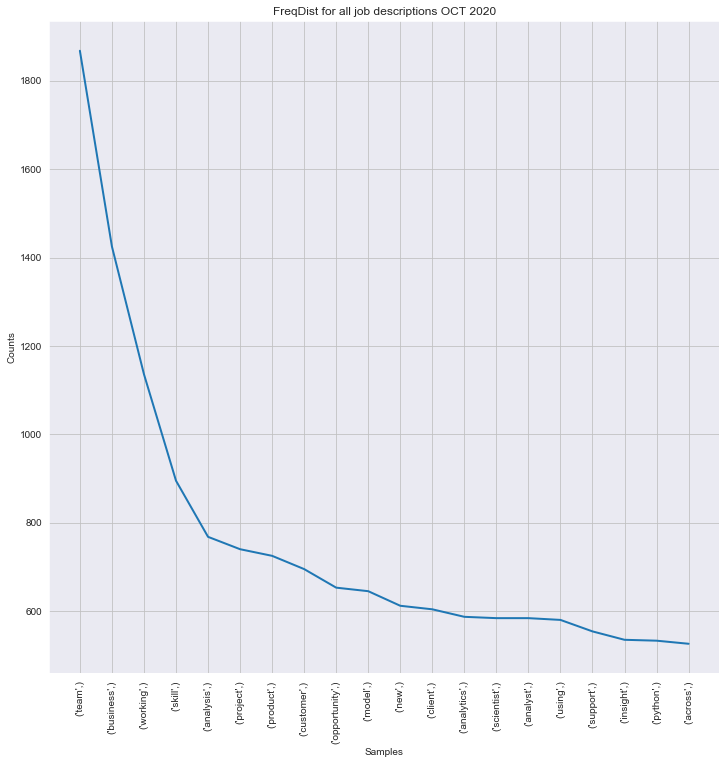

In [20]:
fn.plot_freqdist_from_series(df.job_descr, #the pandas series I am passing in, i.e. the corpus
                            tokenizer, #the tokenizer that will be splitting the text into tokens
                            full_stopwords, #my stopwords that I do not want to see in the final plot
                             'FreqDist for all job descriptions OCT 2020',  #plot title
                             20,  #number of words to display
                             (12,12), #figure size
                             1,  # n-gram size; we'll change this later
                             True); # lowercase all words or not

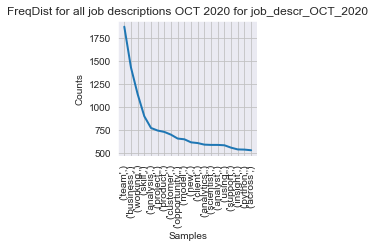

Index(['terms', 'freq_in_job_descr_OCT_2020'], dtype='object')


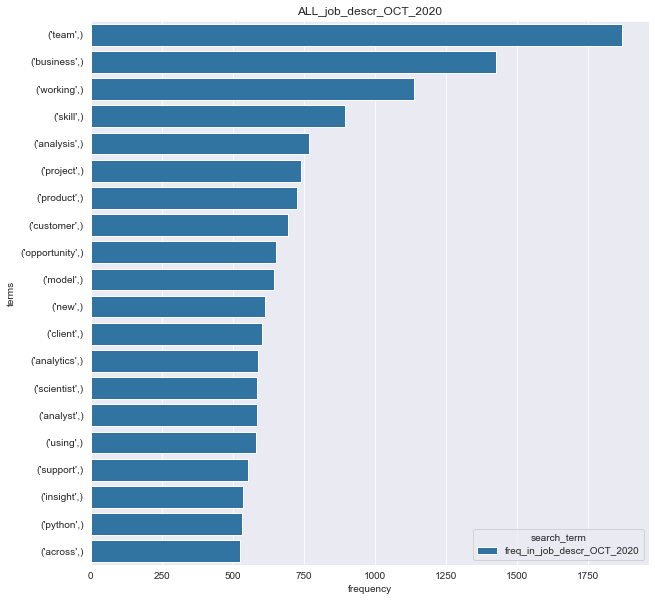

In [35]:
fn.plot_term_bar('ALL_job_descr_OCT_2020', #final title
                 [df.job_descr], # list of pandas series
                 ['job_descr_OCT_2020'], # new df titles
                 tokenizer, # tokenizer
                 full_stopwords,  #stopwords
                 'FreqDist for all job descriptions OCT 2020',); # plot titles

Amongst other things, placing the words horizontally certainly makes them easier to read! Now, are we getting a lot of information out of the plot above? Not necessarily - there's a lot of terms there that seem quite obvious. FreqDist can only tell you so much - but it might be more useful in trying to distinguish different groups text, split by another variable, which is what we will be looking at. In order to lower the amount of redundant words, we'll also use a lemmatizing tokenizer so that we can reduce the number of 'unique' words presented to our analysis. 

In [36]:
df.job_search_term.value_counts()

title: "data scientist"               262
title: "data analyst"                 250
title: "machine learning engineer"     41
Name: job_search_term, dtype: int64

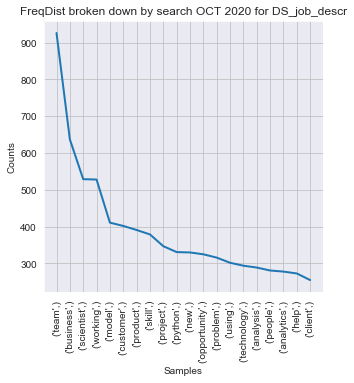

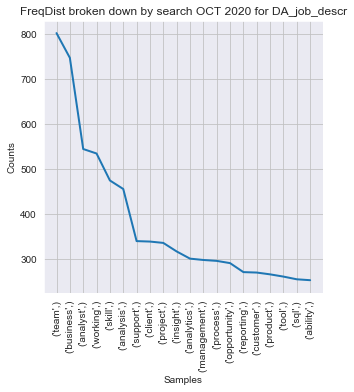

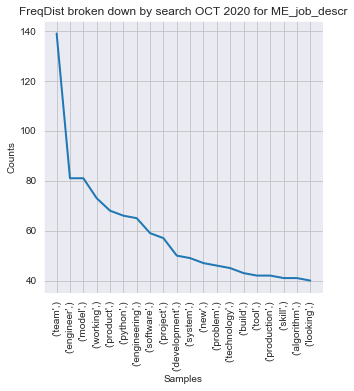

Index(['terms', 'freq_in_DS_job_descr', 'freq_in_DA_job_descr',
       'freq_in_ME_job_descr'],
      dtype='object')


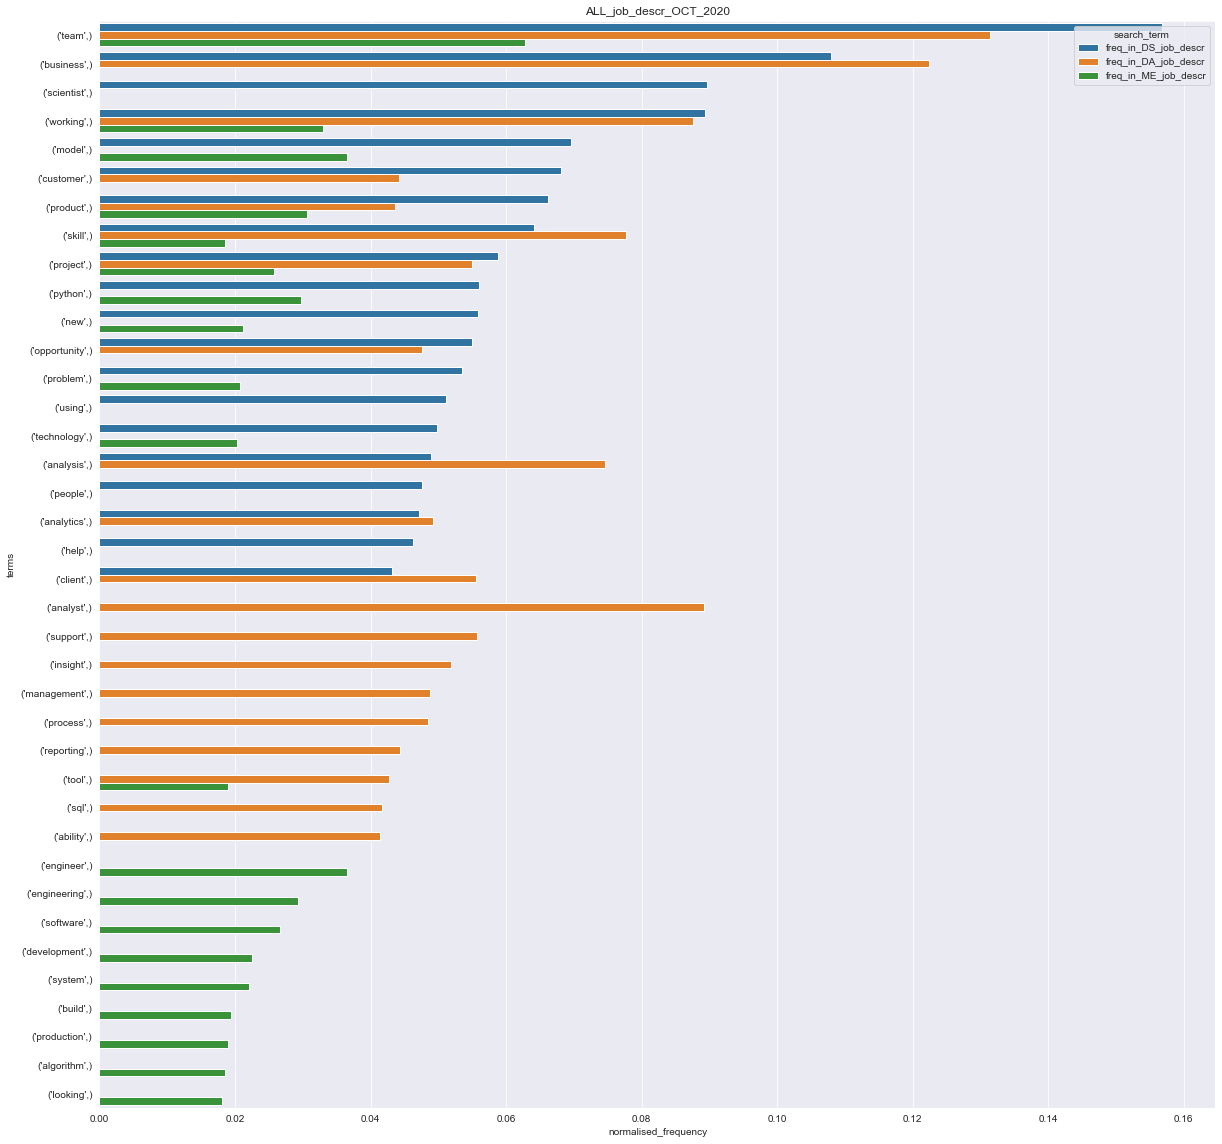

In [49]:
from functions import LemmaTokenizer
lemmy = LemmaTokenizer(tokenizer, full_stopwords)

DS_df = df.loc[df.job_search_term=='title: "data scientist"']
DA_df = df.loc[df.job_search_term=='title: "data analyst"']
ME_df = df.loc[df.job_search_term=='title: "machine learning engineer"']

fn.plot_term_bar('ALL_job_descr_OCT_2020', #final title
                 [DS_df.job_descr, DA_df.job_descr, ME_df.job_descr], # list of pandas series
                 ['DS_job_descr', 'DA_job_descr', 'ME_job_descr'], # new df titles
                 lemmy, # tokenizer
                 full_stopwords,  #stopwords
                 'FreqDist broken down by search OCT 2020', figsize=(20,20)); # plot titles